<a href="https://colab.research.google.com/github/nikxlvii/pytorch/blob/main/image_classification_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from torchvision import datasets

cifar10 = datasets.CIFAR10(root='./data',train = True,download= True)
cifar10_val = datasets.CIFAR10(root='./data',train = False, download = True)

Files already downloaded and verified
Files already downloaded and verified


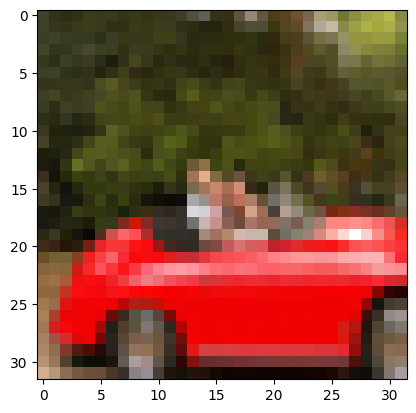

In [62]:
import matplotlib.pyplot as plt

img,label = cifar10[99]
plt.imshow(img)

In [63]:
# we need to convert this rgb pil image to a pytorch tensor for anything to work out at all.

In [64]:
from torchvision import transforms

dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [65]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

It is possible to apply the transform while importing CIFAR10:

tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,transform=transforms.ToTensor())

Note: we have to use permute to change the order of the axes from
C × H × W to H × W × C to match what Matplotlib expects.

In [66]:
tensor_cifar10 = datasets.CIFAR10(root = './data', train=True, download=False,transform=transforms.ToTensor())

In [67]:
# it's good practice to normalize the dataset so that each channel has zero mean and unitary standard deviation.
import torch

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10],dim=3)

In [68]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [69]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [70]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [71]:
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [72]:
transformed_cifar10 = datasets.CIFAR10(root='./data',train=True,download = False,
                                       transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))]))
transformed_cifar10_val = datasets.CIFAR10(root='./data',train=False,download = False,
                                       transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))]))

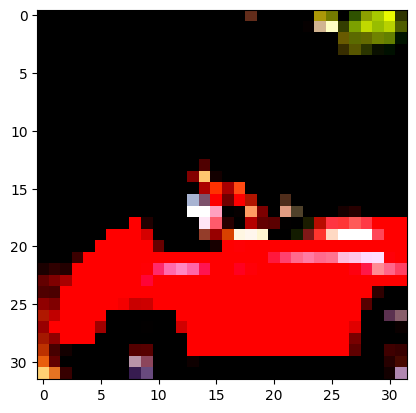

In [73]:
img_t,_= transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))

Now the task here is to classify birds and aeroplanes from each other using a neural network. We'll pick out all the birds and airplanes from our
CIFAR-10 dataset and build a neural network that can tell birds and airplanes apart.

In [74]:
# building a dataset of only birds and aeroplanes

label_map = {0:0,2:1}
class_names = ['airplane','bird']

cifar2 = [(img,label_map[label]) for img, label in transformed_cifar10 if label in [0,2]]

cifar2_val = [(img,label_map[label]) for img, label in transformed_cifar10_val if label in [0,2]]

In [75]:
len(cifar2)

10000

In [76]:
len(cifar2_val)

2000

In [77]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,
        512,
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out,
    )
)

 In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an airplane and torch.tensor([0.0, 1.0]) for a bird. Practically speaking, since our classifier will not be perfect, we can expect the network to output something in between.

Casting the problem in terms of probabilities imposes a few extra constraints on
the outputs of our network:
1. Each element of the output must be in the [0.0, 1.0] range (a probability of
an outcome cannot be less than 0 or greater than 1).
2. The elements of the output must add up to 1.0 (we’re certain that one of the
two outcomes will occur)

Softmax is a function that takes a vector of values and produces another vector of the
same dimension, where the values satisfy the constraints we just listed to represent
probabilities

def softmax(x):
return torch.exp(x) / torch.exp(x).sum()




In [78]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],[1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [79]:
model = nn.Sequential(
    nn.Linear(
        3072,
        512
        ),
    nn.Tanh(),
    nn.Linear(
        512,
        2
        ),
    nn.Softmax(dim=1))


The loss for classification should be focused on maximisng the probability associated with the correct class rather than just classifying it as an extreme.

Likelihood -> probability associated with the correct class. We need a loss function for this which is low when the likelihood is high and vice versa.

We can use Negative Loss Likelihood for this purpose (nn.LogSoftmax)


In [86]:
# Training loop

model = nn.Sequential(
    nn.Linear(
        3072,
        512
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        2
    ),
)

In [82]:
'''learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
  for img, label in cifar2:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_fn(out,torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch,float(loss)))'''

Epoch: 0, Loss: 5.918805
Epoch: 1, Loss: 6.291989
Epoch: 2, Loss: 8.266155
Epoch: 3, Loss: 5.282135
Epoch: 4, Loss: 4.994164
Epoch: 5, Loss: 8.483817
Epoch: 6, Loss: 6.359744
Epoch: 7, Loss: 8.620050
Epoch: 8, Loss: 7.515285
Epoch: 9, Loss: 5.336675
Epoch: 10, Loss: 11.000975
Epoch: 11, Loss: 9.643549
Epoch: 12, Loss: 6.647949
Epoch: 13, Loss: 3.878528
Epoch: 14, Loss: 10.087496
Epoch: 15, Loss: 11.589214
Epoch: 16, Loss: 15.780916
Epoch: 17, Loss: 12.470791
Epoch: 18, Loss: 18.333778
Epoch: 19, Loss: 1.219351
Epoch: 20, Loss: 2.952076
Epoch: 21, Loss: 6.308174
Epoch: 22, Loss: 12.278921
Epoch: 23, Loss: 11.677961
Epoch: 24, Loss: 14.546442
Epoch: 25, Loss: 10.377435
Epoch: 26, Loss: 11.520863
Epoch: 27, Loss: 6.674555
Epoch: 28, Loss: 7.733933
Epoch: 29, Loss: 13.525414
Epoch: 30, Loss: 9.368924
Epoch: 31, Loss: 5.771591
Epoch: 32, Loss: 9.633914
Epoch: 33, Loss: 13.368301
Epoch: 34, Loss: 10.693480
Epoch: 35, Loss: 11.506741
Epoch: 36, Loss: 0.046556
Epoch: 37, Loss: 5.036661
Epoch: 

The torch.utils.data module has a class that helps with shuffling and
organizing the data in minibatches: DataLoader. The job of a data loader is to sample
minibatches from a dataset, giving us the flexibility to choose from different sampling
strategies.

In [87]:
# New training code which includes Dataloader

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    batch_size=imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch,float(loss)))

Epoch: 0, Loss: 0.459570
Epoch: 1, Loss: 0.322957
Epoch: 2, Loss: 0.374659
Epoch: 3, Loss: 0.304135
Epoch: 4, Loss: 0.106098
Epoch: 5, Loss: 0.317071
Epoch: 6, Loss: 0.551318
Epoch: 7, Loss: 0.395194
Epoch: 8, Loss: 0.535702
Epoch: 9, Loss: 0.543112
Epoch: 10, Loss: 0.220699
Epoch: 11, Loss: 0.436446
Epoch: 12, Loss: 0.122577
Epoch: 13, Loss: 0.310596
Epoch: 14, Loss: 0.212793
Epoch: 15, Loss: 0.237014
Epoch: 16, Loss: 0.229860
Epoch: 17, Loss: 0.219779
Epoch: 18, Loss: 0.400752
Epoch: 19, Loss: 0.202713
Epoch: 20, Loss: 0.370022
Epoch: 21, Loss: 0.291846
Epoch: 22, Loss: 0.249747
Epoch: 23, Loss: 0.077759
Epoch: 24, Loss: 0.156231
Epoch: 25, Loss: 0.129402
Epoch: 26, Loss: 0.231652
Epoch: 27, Loss: 0.219758
Epoch: 28, Loss: 0.226065
Epoch: 29, Loss: 0.432302
Epoch: 30, Loss: 0.193058
Epoch: 31, Loss: 0.260616
Epoch: 32, Loss: 0.129131
Epoch: 33, Loss: 0.130298
Epoch: 34, Loss: 0.127095
Epoch: 35, Loss: 0.102429
Epoch: 36, Loss: 0.359557
Epoch: 37, Loss: 0.342772
Epoch: 38, Loss: 0.118

In [88]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

correct = 0
total = 0
with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
  print("Accuracy: %f", correct / total)

Accuracy: %f 0.802


The model is overfitted. We will solve this by using convolutional neural networks.